# Gaussian Process Multi-Class Classification

## Preliminary steps

### Loading necessary packages
## Data generation and setting up packages

In [1]:
using Plots
using Distributions
using AugmentedGaussianProcesses

### Generate data from a mixture of gaussians (you can control the noise)

In [2]:
n_data = 300
n_dim = 2
n_grid = 100
minx = -2.5;
maxx = 3.5;

### We try different noises (different overlaps)

In [3]:
σs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
n_class = n_dim + 1;

### We create a function generating a mixture of Gaussians

In [4]:
function generate_mixture_data(σ)
    centers = zeros(n_class, n_dim)
    # Create equidistant centers
    for i in 1:n_dim
        centers[i, i] = 1.0
    end
    centers[end, :] .= (1 + sqrt(n_class)) / n_dim
    centers ./= sqrt(n_dim)
    # Generate distributions with desired noise
    distr = [MvNormal(centers[i, :], σ) for i in 1:n_class]
    X = zeros(Float64, n_data, n_dim)
    y = zeros(Int64, n_data)
    for i in eachindex(y)
        y[i] = rand(1:n_class)
        X[i, :] = rand(distr[y[i]])
    end
    return X, y
end

generate_mixture_data (generic function with 1 method)

### And a function to plot the data

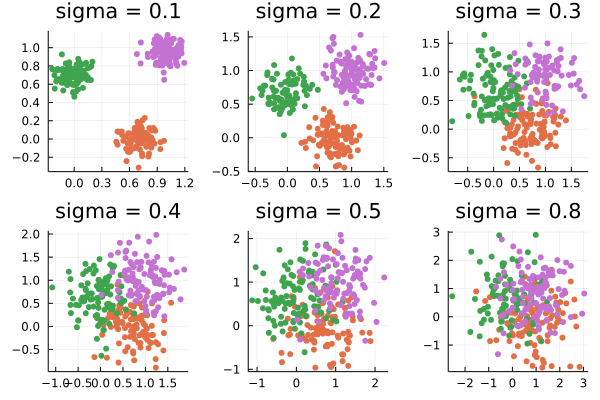

In [5]:
function plot_data(X, Y, σ)
    p = Plots.plot(size(300, 500); lab="", title="sigma = $σ")
    Plots.scatter!(eachcol(X)...; group=Y, msw=0.0, lab="")
    return p
end

plot([plot_data(generate_mixture_data(σ)..., σ) for σ in σs]...)

## Model training
### Run sparse multiclass classification with different level of noise

In [6]:
models = Vector{AbstractGPModel}(undef, length(σs))
kernel = SqExponentialKernel()
num_inducing = 50
for (i, σ) in enumerate(σs)
    @info "Training with data with noise $σ"
    X, y = generate_mixture_data(σ)
    m = SVGP(
        kernel,
        LogisticSoftMaxLikelihood(n_class),
        AnalyticVI(),
        inducingpoints(KmeansAlg(num_inducing), X);
        optimiser=false,
        Zoptimiser=false,
    )
    @time train!(m, X, y, 20)
    models[i] = m
end

[ Info: Training with data with noise 0.1
  5.353383 seconds (8.25 M allocations: 490.447 MiB, 3.59% gc time, 96.61% compilation time)
[ Info: Training with data with noise 0.2
  0.035779 seconds (5.96 k allocations: 37.813 MiB)
[ Info: Training with data with noise 0.3
  0.035127 seconds (5.96 k allocations: 37.813 MiB)
[ Info: Training with data with noise 0.4
  0.037414 seconds (5.96 k allocations: 37.813 MiB)
[ Info: Training with data with noise 0.5
  0.030676 seconds (5.96 k allocations: 37.813 MiB)
[ Info: Training with data with noise 0.8
  0.030417 seconds (5.96 k allocations: 37.813 MiB)


### Function to create predictions and plot them

In [7]:
function compute_grid(model, n_grid=50)
    xlin = range(minx, maxx; length=n_grid)
    ylin = range(minx, maxx; length=n_grid)
    x_grid = Iterators.product(xlin, ylin)
    y_p = proba_y(model, vec(collect.(x_grid)))
    y = predict_y(model, vec(collect.(x_grid)))
    return y_p, y, xlin, ylin
end;

function plot_contour(model, σ)
    n_grid = 100
    pred_proba, pred, x, y = compute_grid(model, n_grid)
    colors = reshape(
        [
            RGB([pred_proba[model.likelihood.ind_mapping[j]][i] for j in 1:n_class]...) for
            i in 1:(n_grid^2)
        ],
        n_grid,
        n_grid,
    ) # Convert the predictions into an RGB array
    Plots.contour(
        x,
        y,
        colors;
        cbar=false,
        fill=false,
        color=:black,
        linewidth=2.0,
        title="sigma = $σ",
    )
    return Plots.contour!(
        x,
        y,
        reshape(pred, n_grid, n_grid);
        clims=(0, 100),
        colorbar=false,
        color=:gray,
        levels=10,
    )
end;

### Plot the final results

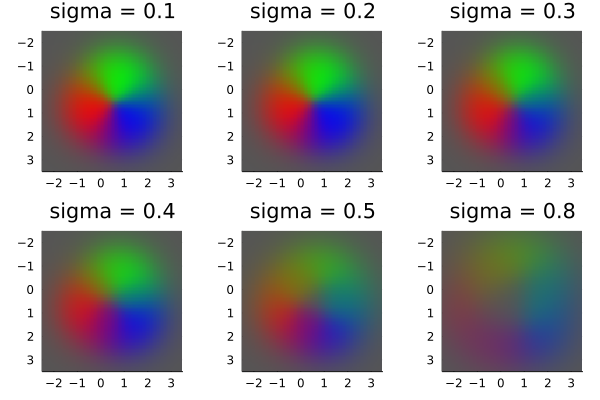

In [8]:
Plots.plot(plot_contour.(models, σs)...)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*